# Kaggle - Football Prediction

## Introduction

This notebook was created to participate in the `Football Match Probability Prediction` competition on `kaggle.com` (https://www.kaggle.com/competitions/football-match-probability-prediction/data). The competition's goal is to **use machine learning models** to predict the probabilities of the outcome of football matches.

## Start of the project

### Import modules

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV

In [4]:
from imblearn.over_sampling import RandomOverSampler

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [155]:
import tensorflow
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

### Import data

To avoid warnings, the data types for the descriptive features (see below) are defined before importing the data:

* target - draw, home or away depending on what team won the game.
* home_team_name - name of the Home team.
* away_team_name - name of the Away team.
* match_date - match date (UTC).
* league_name - league name.
* league_id - league id; note that league names can be identical for two differents id.
* is_cup - if 1 the match is played for a cup competition.
* home_team_coach_id - id of the Home team coach.
* away_team_coach_id - id of the Away team coach.

In [7]:
column_dtypes = {'target': 'object', 'home_team_name': 'object', 'away_team_name': 'object', 'league_name': 'object',
          'is_cup': 'int64', 'home_team_coach_id': 'float64', 'away_team_coach_id': 'float64'}

In [8]:
train_data = pd.read_csv('train.csv', dtype=column_dtypes, index_col=[0], header=0, parse_dates=['match_date'])

In [9]:
train_data.rename_axis(None, inplace=True)

In [10]:
del column_dtypes['target']

In [11]:
test_data = pd.read_csv('test.csv', dtype=column_dtypes, index_col=[0], header=0, parse_dates=['match_date'])

In [12]:
test_data.rename_axis(None, inplace=True)

### Exploratory Data Analysis

#### Target classes

In [13]:
train_data['target'].value_counts(normalize=True, sort=True) * 100

home    43.369269
away    31.705998
draw    24.924733
Name: target, dtype: float64

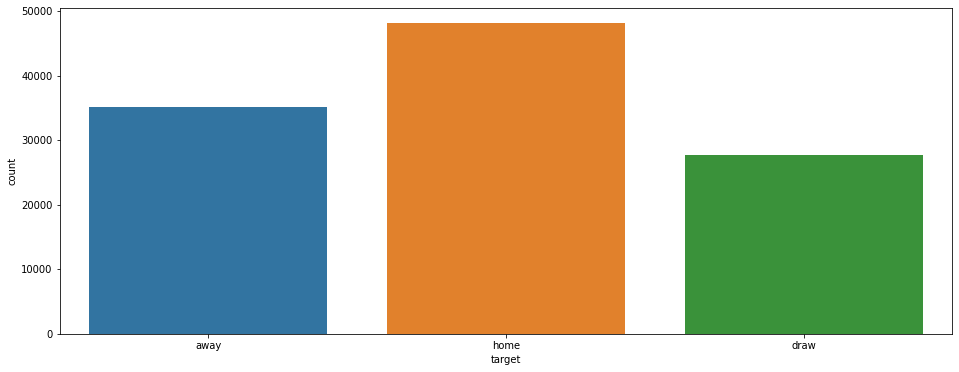

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.countplot(data=train_data, x='target', ax=ax)
plt.show()

**Three classes**: home team win, away team win and draw. There might be a problem of label imbalance. Keep that in mind (will be addressed during data preprocessing). Moreover, it might be necessary to encode the strings as integer values, so that all machine learning models are able to process the targets.

In [15]:
train_data['target'] = train_data['target'].map({'draw': 0, 'home': 1, 'away': 2})

#### Features

Stated on the Kaggle competition webpage: *'The features provided are divided into two parts: the descriptive features and the historical features. Descriptive features are point-in-time descriptions of the match that has to be predicted. Historical features contain past information of the 10 games previously played by the Home and the Away team.'*

Hence, we differentiate between descriptive as well as historical features during the EDA.

In [16]:
desc_features = list(train_data.columns[1:9])

In [17]:
hist_features = list(train_data.columns[9:])

#### Descriptive features

In [18]:
# train_data[desc_features].info()

As indicated by the table, there are missing values:

In [19]:
for col in desc_features:
    print(f'{col}: {train_data[col].isnull().sum()} missing values')

home_team_name: 1 missing values
away_team_name: 1 missing values
match_date: 0 missing values
league_name: 1 missing values
league_id: 0 missing values
is_cup: 0 missing values
home_team_coach_id: 21721 missing values
away_team_coach_id: 21815 missing values


Missing value in features `home_team_name`, `away_team_name` and `league_name` all belong to same index. Hence, the row will be removed from dataset.

In [20]:
# train_data[train_data['home_team_name'].isnull()].index[0]

In [21]:
# train_data[train_data['away_team_name'].isna()].index[0]

In [22]:
# train_data[train_data['league_name'].isna()].index[0]

In [23]:
train_data.drop(index=train_data[train_data['home_team_name'].isnull()].index[0], axis=0, inplace=True)

Missing values in the remaining two features `home_team_coach_id` & `away_team_coach_id` are not relevant, as they will be removed in the next step. Assumption: id-features do not contain useful information when trying to predict the outcome of football matches. Moreover, names of teams are assumed to have no impact. Drop the features as well.

In [24]:
for column in ['league_id', 'home_team_coach_id', 'away_team_coach_id']:
    print(f'Correlation between target and {column}: {round(train_data[["target", column]].corr().iloc[0, 1], 2)}')

Correlation between target and league_id: 0.01
Correlation between target and home_team_coach_id: 0.02
Correlation between target and away_team_coach_id: -0.01


In [25]:
train_data.drop(columns = ['home_team_name', 'away_team_name', 'league_name', 'league_id',
                           'home_team_coach_id', 'away_team_coach_id'], axis=1, inplace=True)

In [26]:
test_data.drop(columns = ['home_team_name', 'away_team_name', 'league_name', 'league_id',
                          'home_team_coach_id', 'away_team_coach_id'], axis=1, inplace=True)

#### Historical features

In [27]:
# train_data[hist_features].info()

Are there missing values for the historical features as well?

In [28]:
#for col in hist_features:
#    print(f'{col}: {train_data[col].isnull().sum()} missing values')

There are a lot of missing values (see also cells below). They will be addressed during the following examination.

In [29]:
print('Training data contains {:,.0f} missing values.'.format(sum(train_data.isna().sum())))

Training data contains 1,673,716 missing values.


In [30]:
print(f'That represents {round(sum(train_data.isna().sum()) / len(train_data), 1)}% percent of the training dataset.')

That represents 15.1% percent of the training dataset.


Due to vast amount of features the examination is **divided into several units**.

<u>home_team_history_match_date_X</u>
* First ten features are related to historical match dates (categorical feature).
* Each entry is a date. Hence, the data type is changed.
* Missing values are replaced with the mode value.

In [31]:
# train_data[hist_features[0:10]].info()

In [32]:
for feat in hist_features[0:10]:
    train_data[feat].fillna(train_data[feat].mode()[0], inplace=True)
    test_data[feat].fillna(test_data[feat].mode()[0], inplace=True)

In [33]:
train_data[hist_features[0:10]] = train_data[hist_features[0:10]].astype('datetime64[ns]')

In [34]:
test_data[hist_features[0:10]] = test_data[hist_features[0:10]].astype('datetime64[ns]')

<u>home_team_history_is_play_home_X</u>
* Second subset contains features indicating whether the home team played the historical match at home (true or false, 1 or 0; numerical feature)
* Missing values are replaced with median value.

In [35]:
# train_data[hist_features[10:20]].info()

In [36]:
for feat in hist_features[10:20]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>home_team_history_is_cup_X</u>
* Third subset: is the historical match a cup match? (true or false, 1 or 0; numerical feature)
* Missing values are replaced with median value.

In [37]:
# train_data[hist_features[20:30]].info()

In [38]:
for feat in hist_features[20:30]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>home_team_history_goal_X</u>
* Fourth subset: number of goals the home team scored in the historical match (numerical feature).
* Missing values are replaced with median value.

In [39]:
# train_data[hist_features[30:40]].info()

In [40]:
for feat in hist_features[30:40]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>home_team_history_opponent_goal_X</u>
* Fifth subset: number of goals the home team's opponent scored in the historical match (numerical feature).
* Missing values are replaced with median value.

In [41]:
# train_data[hist_features[40:50]].info()

In [42]:
for feat in hist_features[40:50]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>home_team_history_rating_X</u>
* Sixth subset: home team's rating for the historical match (numerical feature).
* Missing values are replaced with median value.

In [43]:
# train_data[hist_features[50:60]].info()

In [44]:
for feat in hist_features[50:60]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>home_team_history_opponent_rating_X</u>
* Seventh subset: home team's opponent's rating for the historical match (numerical feature).
* Missing values are replaced with median value.

In [45]:
# train_data[hist_features[60:70]].info()

In [46]:
for feat in hist_features[60:70]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>home_team_history_coach_X</u>
* Eight subset: ID of the home team coach.
* Will be dropped due to reasons already discussed.

In [47]:
# train_data[hist_features[70:80]].info()

In [48]:
for column_index in range(70, 80):
    column = hist_features[column_index]
    print(f'Correlation between target and {column}: {round(train_data[["target", column]].corr().iloc[0, 1], 2)}')

Correlation between target and home_team_history_coach_1: 0.02
Correlation between target and home_team_history_coach_2: 0.02
Correlation between target and home_team_history_coach_3: 0.02
Correlation between target and home_team_history_coach_4: 0.02
Correlation between target and home_team_history_coach_5: 0.02
Correlation between target and home_team_history_coach_6: 0.02
Correlation between target and home_team_history_coach_7: 0.02
Correlation between target and home_team_history_coach_8: 0.02
Correlation between target and home_team_history_coach_9: 0.02
Correlation between target and home_team_history_coach_10: 0.01


<u>home_team_history_league_id_X</u>
* Ninth subset: home team's league ID.
* Will be dropped due to reasons already discussed.

In [49]:
# train_data[hist_features[80:90]].info()

In [50]:
for column_index in range(80, 90):
    column = hist_features[column_index]
    print(f'Correlation between target and {column}: {round(train_data[["target", column]].corr().iloc[0, 1], 2)}')

Correlation between target and home_team_history_league_id_1: 0.01
Correlation between target and home_team_history_league_id_2: 0.01
Correlation between target and home_team_history_league_id_3: 0.01
Correlation between target and home_team_history_league_id_4: 0.01
Correlation between target and home_team_history_league_id_5: 0.01
Correlation between target and home_team_history_league_id_6: 0.01
Correlation between target and home_team_history_league_id_7: 0.0
Correlation between target and home_team_history_league_id_8: 0.01
Correlation between target and home_team_history_league_id_9: 0.0
Correlation between target and home_team_history_league_id_10: 0.0


Remaining subsets are **related to the away team** and contain **similar information** presented above for the home team. Hence, they are processed in the same way.

<u>away_team_history_match_date_X</u>

In [51]:
# train_data[hist_features[90:100]].info()

In [52]:
for feat in hist_features[90:100]:
    train_data[feat].fillna(train_data[feat].mode()[0], inplace=True)
    test_data[feat].fillna(test_data[feat].mode()[0], inplace=True)

In [53]:
train_data[hist_features[90:100]] = train_data[hist_features[90:100]].astype('datetime64[ns]')

In [54]:
test_data[hist_features[90:100]] = test_data[hist_features[90:100]].astype('datetime64[ns]')

<u>away_team_history_is_play_home_X</u>

In [55]:
# train_data[hist_features[100:110]].info()

In [56]:
for feat in hist_features[100:110]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>away_team_history_is_cup_X</u>

In [57]:
# train_data[hist_features[110:120]].info()

In [58]:
for feat in hist_features[110:120]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>away_team_history_goal_X</u>

In [59]:
# train_data[hist_features[120:130]].info()

In [60]:
for feat in hist_features[120:130]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>away_team_history_opponent_goal_X</u>

In [61]:
# train_data[hist_features[130:140]].info()

In [62]:
for feat in hist_features[130:140]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>away_team_history_rating_X</u>

In [63]:
# train_data[hist_features[140:150]].info()

In [64]:
for feat in hist_features[140:150]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>away_team_history_opponent_rating_X</u>

In [65]:
# train_data[hist_features[150:160]].info()

In [66]:
for feat in hist_features[150:160]:
    train_data[feat].fillna(train_data[feat].median(), inplace=True)
    test_data[feat].fillna(test_data[feat].median(), inplace=True)

<u>away_team_history_coach_X</u>

In [67]:
# train_data[hist_features[160:170]].info()

<u>away_team_history_league_id_X</u>

In [68]:
# train_data[hist_features[170:180]].info()

Finally, drop irrelevant ID columns:

In [69]:
train_data.drop(columns=hist_features[70:80], axis=1, inplace=True)
test_data.drop(columns=hist_features[70:80], axis=1, inplace=True)
train_data.drop(columns=hist_features[80:90], axis=1, inplace=True)
test_data.drop(columns=hist_features[80:90], axis=1, inplace=True)
train_data.drop(columns = hist_features[160:170], axis = 1, inplace = True)
test_data.drop(columns = hist_features[160:170], axis = 1, inplace = True)
train_data.drop(columns = hist_features[170:180], axis = 1, inplace = True)
test_data.drop(columns = hist_features[170:180], axis = 1, inplace = True)

Next, we create new features based on all date-based features. The newly created features indicate the difference (counted in days) between the match date and the respective historical match:

In [70]:
for i in range(1, 11):
    home_column = f'home_team_history_match_date_{i}'
    away_column = f'away_team_history_match_date_{i}'

    train_data[f'home_team_history_match_days_ago_{i}'] = (train_data['match_date'] - train_data[home_column]).dt.days
    train_data[f'away_team_history_match_days_ago_{i}'] = (train_data['match_date']- train_data[away_column]).dt.days

Same procedure for the test data:

In [71]:
for i in range(1, 11):
    home_column = f'home_team_history_match_date_{i}'
    away_column = f'away_team_history_match_date_{i}'

    test_data[f'home_team_history_match_days_ago_{i}'] = (test_data['match_date'] - test_data[home_column]).dt.days
    test_data[f'away_team_history_match_days_ago_{i}'] = (test_data['match_date'] - test_data[away_column]).dt.days

Eventually, all date-based features are dropped:

In [72]:
train_data_date_based_columns = train_data.select_dtypes(include='datetime64[ns]').columns
test_data_date_based_columns = test_data.select_dtypes(include='datetime64[ns]').columns

In [73]:
train_data.drop(columns = train_data_date_based_columns, axis=1, inplace=True)

In [74]:
test_data.drop(columns = test_data_date_based_columns, axis=1, inplace=True)

### Preprocessing the data

#### Remaining missing values?

In [75]:
sum(train_data.isna().sum())

0

In [76]:
sum(test_data.isna().sum())

0

Perfect!

#### Resampling to remove imbalance in targets

First, separate features from targets/labels:

In [77]:
features = train_data.drop(columns=['target'], axis=1)

In [78]:
targets = train_data.loc[:, 'target']

As stated at the beginning the labels are imbalanced. To avoid biased results, **resampling** is applied. In particular, **random oversampling** is applied.

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset. Note that problems of overfitting might be amplified by that procedure.

Alternatively, one could apply **undersampling** (reduce the majority class; problem: loss of crucial data) or **Synthetic Minority Oversampling Technique (SMOTE)** (generate new synthetic samples in minority class by slightly modifying existing samples).

In [79]:
random_oversampler = RandomOverSampler(random_state=42)

In [80]:
resampled_data = random_oversampler.fit_resample(features, targets)

In [81]:
features_after_resampling = pd.DataFrame(list(resampled_data[:-1])[0])

In [82]:
targets_after_resampling = resampled_data[-1]

#### Feature Scaling

What is feature scaling? It is a preprocessing technique that transforms values to a similar scale, ensuring all features contribute equally to the model. In many cases, features are characterized by varying ranges, units, or magnitudes. Scaling improves the model's performance and prevents bias from features with relatively large values.

Feature scaling can be achieved by **standardization** and **normalization**.

* **Standardization**: values are centered around the mean with a unit standard deviation.
* **Normalization** (often called **Min-max scaling**): values are shifted and rescaled so that they end up ranging between 0 and 1.

The choice between standardization and normalization depend on the problem, the dataset and the machine learning algorithm. One feasible way is to fit the model to raw, normalized, and standardized data and compare the performance.

Sources:
* https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
* https://www.datacamp.com/tutorial/normalization-in-machine-learning

In [83]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

In [84]:
features_scaled = scaler.fit_transform(features_after_resampling)

In [85]:
features_test_scaled = scaler.transform(test_data)

#### Training and validation set split

In [86]:
features_train, features_valid, targets_train, targets_valid = train_test_split(features_scaled, targets_after_resampling,
                                                                                test_size=0.1, shuffle=True)

### Modelling

#### Cross-validation strategy & performance metric

First, we choose a **cross-validation strategy**. Cross-validation is a technique for evaluating models by training several models on subsets of the available input data and evaluating them on another subset of the data. The technique allows to detect overfitting. There are a lot of different approaches, but all of them have a similar algorithm:

1. Divide the dataset into two subsets: one for training, other for validation.
2. Train the model on the training set.
3. Validate the model on the test set.
4. Repeat 1-3 steps a couple of times (depending on the approach).

A popular approach is the **k-fold** cross-validation, which applies the following iterative process:

1. Pick a number of folds (k).
2. Split the dataset into k subsets (folds).
3. Choose k – 1 folds as the training subsets.
4. Train the model on the training subsets.
5. Validate on the remaining validation subset.
6. Save the results.
7. Repeat steps 3 – 6 k times. In step 3: do not pick the same k - 1 subsets as in the previous iteration. In the end, the model should have been validated on every fold!
8. Calculate the final score by averaging all results.

In this case, we will stick to **stratified cross-validation**. It is a variation of k-fold with stratified folds: each fold contains approximately the same percentage of samples of each target class as the complete dataset.

Sources:
* https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right

In [87]:
stratified_cross_valid_folds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

To evaluate the model's performance, we have to choose a **performance metric**. In the following, the most commonly used metrics are described:

* **Accuracy** = **(TP + TN) / (TP + FP + TN + FN)**, where TP: true positive, FP: false positive, TN: true negative, and FN: false negative. It shows the proportion of correctly predicted results.

* **Precision** = **TP / (TP + FP)**. Proportion of true positive predictions among all positive predictions. Ability of the classifier **not** to label a negative sample as positive.

* **Recall** = **TP / (TP + FN)**. Proportion of true positive predictions among all actual positive instances. Ability of the classifier to find all the positive samples.

* **F1-score**: can be interpreted as a weighted harmonic mean of the precision and recall, where the score reaches its best value at 1 and worst score at 0.

However, it is stated on kaggle competition page that the results are evaluated using **multinomial log-loss**. Multinomial log-loss (also known as **logistic** or **cross-entropy loss**) is a loss function used in machine learning to measure the performance of a **classification model**. It measures the difference between the predicted probability distribution and the true distribution:

$$
    L(p,q)= - \sum p(x) \ln q(x)
$$


As it is the metric used for the competition, we will continue with log-loss to measure model perfomance.

In [88]:
def get_log_loss(model):
    fitted_model = model.fit(features_train, targets_train)
    
    predictions_train = fitted_model.predict_proba(features_train)
    train_log_loss = log_loss(targets_train, predictions_train)
    
    predictions_valid = fitted_model.predict_proba(features_valid)
    valid_log_loss = log_loss(targets_valid, predictions_valid)
    
    print(f'Training: {round(train_log_loss * 100, 2)} vs. Validation: {round(valid_log_loss * 100, 2)}')

Finally, the cross-val-score of sklearn is implemented in a function to cross-validate models. **Note**: function uses complete training data without split as validation is applied internally.

In [94]:
def cross_validate_model(model, X=features_scaled, y=targets_after_resampling):
    return cross_val_score(model, X, y, cv=stratified_cross_valid_folds, scoring='neg_log_loss')

#### Decision Tree Classifier

We start with a simple Decision Tree classifier without parameter tuning:

In [90]:
decision_tree_baseline = DecisionTreeClassifier(random_state=42)

In [91]:
get_log_loss(decision_tree_baseline)

Training: 0.16 vs. Validation: 1292.85


Cross-validation not performed due to time and computational power restrictions.

In [92]:
# decision_tree_baseline_log_loss_cv = cross_validate_model(decision_tree_baseline).mean()

As expected, the decision tree baseline model learns the data structure by heart and yields a log-loss of almost 0. The log-loss on the validation set is around 1,300 percent. The huge gap indicates (expected) issues of **overfitting**. In the following, different **levels of depth** are tested to see whether a better performance (and lower overfitting gap) can be yielded.

In [93]:
depths = np.arange(1, 21, 1)

In [95]:
depth_log_losses_train = []
depth_log_losses_valid = []

In [96]:
for depth in depths:
    temp_dec_tree = DecisionTreeClassifier(max_depth=depth, random_state=42).fit(features_train, targets_train)
    depth_log_losses_train.append(log_loss(targets_train, temp_dec_tree.predict_proba(features_train)))
    depth_log_losses_valid.append(log_loss(targets_valid, temp_dec_tree.predict_proba(features_valid)))

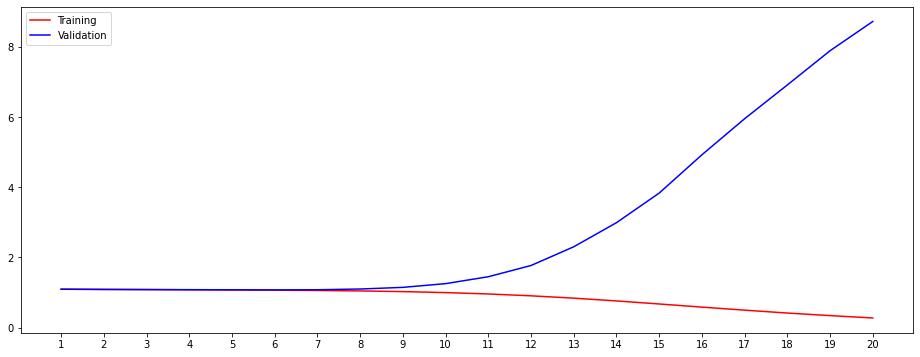

In [97]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(depths, depth_log_losses_train, color='red', label='Training')
ax.plot(depths, depth_log_losses_valid, color='blue', label='Validation')
ax.set_xticks(depths)
ax.legend()
plt.show()

In [98]:
difference_train_valid = [v - t for v,t in zip(depth_log_losses_train, depth_log_losses_valid)]

In [99]:
decision_tree_log_losses = pd.DataFrame([depth_log_losses_train, depth_log_losses_valid, difference_train_valid],
                                                  index=['Training', 'Validation', 'Difference'],
                                                  columns=depths).T

In [100]:
decision_tree_log_losses.loc[9:11]

,Training,Validation,Difference
9,1.023565,1.144154,-0.120589
10,0.995487,1.250677,-0.255190
11,0.955942,1.447467,-0.491526


Problem of overfitting is quite obvious. We will continue with a **depth of 10** (afterwards the curves diverges siginificantly).

In [101]:
decision_tree_final = DecisionTreeClassifier(max_depth=10, random_state=42).fit(features_train, targets_train)

Make predictions with tuned model and evaluate:

In [102]:
decision_tree_predictions = decision_tree_final.predict(features_valid)

Check **confusion matrix** to evaluate model performance.

The **confusion matrix**, also known as error matrix, is a specific table that allows visualization of the **performance of an algorithm**. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa. The diagonal of the matrix therefore **represents all instances that are correctly predicted**.

In [103]:
decision_tree_confusion_matrix = confusion_matrix(targets_valid, decision_tree_predictions)

In [104]:
decision_tree_confusion_matrix_plot = ConfusionMatrixDisplay(decision_tree_confusion_matrix,
                                                             display_labels = np.array(['draw', 'home', 'away']))

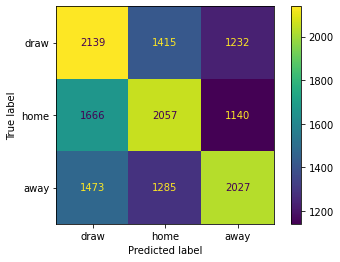

In [105]:
decision_tree_confusion_matrix_plot.plot()

As already indicated by the line plot comparing log-losses on training and validation set, the log-loss around **1 and 1.5**. Next, feature importance is examined to see whether features could be excluded to reduce complexity.

In [107]:
feature_importance = pd.Series(decision_tree_final.feature_importances_,
                               index = features.columns).sort_values(ascending = False)

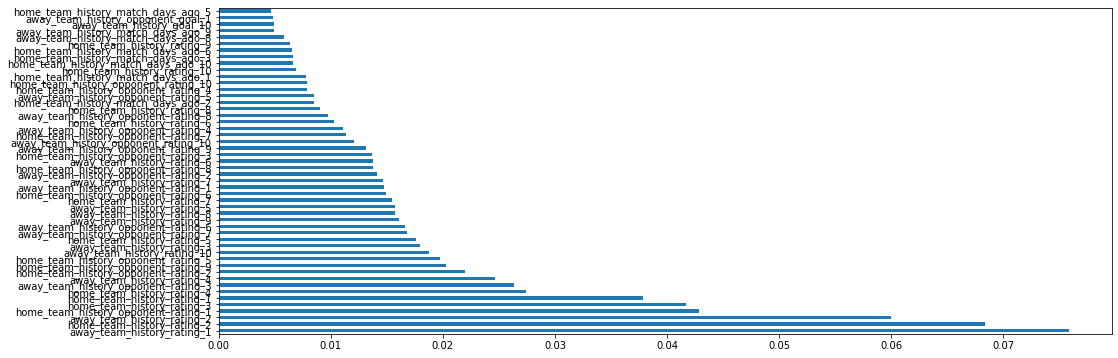

In [108]:
fig, ax = plt.subplots(figsize=(16, 6))
feature_importance.head(50).plot(kind='barh', ax=ax)
plt.show()

The charts indicate that the **most important features** are those related to the **team ratings**. In the following, only rating features are considered to fit a decision tree model.

In [109]:
rating_features = hist_features[50:70] + hist_features[140:160]

In [110]:
features_sparse_scaled = scaler.fit_transform(features_after_resampling[rating_features])
features_test_sparse_scaled = scaler.transform(test_data[rating_features])
features_sparse_train, features_sparse_valid, targets_sparse_train, targets_sparse_valid = train_test_split(features_sparse_scaled,
                                                                                                            targets_after_resampling,
                                                                                                            test_size=0.1,
                                                                                                            shuffle=True)

In [111]:
decision_tree_sparse = DecisionTreeClassifier(max_depth=10, random_state=42).fit(features_sparse_train, targets_sparse_train)

In [112]:
decision_tree_sparse_predictions = decision_tree_sparse.predict_proba(features_sparse_valid)

In [113]:
log_loss(targets_valid, decision_tree_sparse_predictions)

1.534729091333382

Similar results. Up to the next model.

#### Random Forest Classifier

As with the single Decision Tree Classifier, we start with a Random Forest Classifier without parameter tuning.

In [114]:
random_forest_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)

In [115]:
get_log_loss(random_forest_baseline)

Training: 19.02 vs. Validation: 71.48


Cross-validation not performed due to time and computational power restrictions.

In [116]:
# random_forest_baseline_log_loss_cv = cross_validate_model(random_forest_baseline).mean()

Similar to the Decision Tree results, we observe **overfitting** for the baseline Random Forest. However, the performance on the validation set is already significantly better compared to the single Decision Tree baseline model. Following, parameter tuning is applied to test several Random Forest classifiers. The tuning is done via `GridSearch` form sklearn. **Note**: code is excluded via comments due to time and computational power restrictions.

In [117]:
# random_forest_params = {'n_estimators': [100, 300], 'max_features': [None, 'sqrt']}

In [118]:
# random_forest_grids = GridSearchCV(random_forest_baseline, param_grid=random_forest_params,
#                                   cv=stratified_cross_valid_folds, scoring='accuracy', n_jobs=-1)

**Note**: model is fitted on complete training data without split as `GridSearchCV` does the validation internally.

In [119]:
# random_forest_grids_fitted = random_forest_grids.fit(features_scaled, targets_after_resampling)

In [120]:
# random_forest_grids_results = pd.DataFrame(random_forest_grids_fitted.cv_results_)

In [121]:
# random_forest_grids_fitted.best_estimator_

In [122]:
# random_forest_grids_mean_results = np.array(random_forest_grids_results.mean_test_score).reshape(2, 2).T
# fig, ax = plt.subplots(figsize=(16, 6))
# sns.heatmap(random_forest_grids_mean_results, xticklabels=random_forest_params['max_features'],
#             yticklabels=random_forest_params['n_estimators'],
#             linecolor='red', linewidths = 1, cmap='viridis', ax=ax)
# ax.set_xlabel('max_features')
# ax.set_ylabel('n_estimators')
# plt.show()

No real differences between parameter combinations. Hence, a random forest model with 100 estimators and `max_features` set to `None` is fitted.

In [123]:
random_forest_final = RandomForestClassifier(n_estimators=100, max_features=None,
                                             random_state=42, n_jobs=-1).fit(features_train, targets_train)

In [124]:
random_forest_predictions = random_forest_final.predict(features_valid)

In [125]:
random_forest_confusion_matrix = confusion_matrix(targets_valid, random_forest_predictions)

In [126]:
random_forest_confusion_matrix_plot = ConfusionMatrixDisplay(random_forest_confusion_matrix,
                                                        display_labels=np.array(['draw', 'home', 'away']))

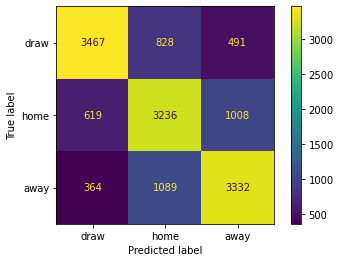

In [127]:
random_forest_confusion_matrix_plot.plot()

In [128]:
log_loss(targets_valid, random_forest_final.predict_proba(features_valid))

0.7174671514040438

As expected, the random forest model is **better by a huge margin** (around 1/2 of the log-loss on the validation subset) compared to the single Decision tree classifier.

#### XGB Classifier

Next, a eXtreme Gradient Boosting Classifier is applied on the data.

* **Gradient boosting** involves creating and adding new Decision Trees to the model sequentially. The new trees are created to correct the residual errors in the predictions from the previous trees.
* The drawback to that model is that it tends to **overfit**.
* To accomodate for that drawback, a weighting factor can be applied for the corrections by new trees. This weighting is called the **shrinkage factor** or **learning rate**. Common values for the learning rate range between **0.1 and 0.3**. But values less than 0.1 are feasible as well.
* Lastly, **extreme** indicates the high computational speed.

As for the Random Forest, we use **100 estimators** and `max_features` set to `None`. Moreover, the following parameters (besides `random_state` & `n_jobs` are set:

* `learning_rate`: see above.
* `objective` (learning objective): **multi:softmax**, recommended for multiclass classification.
* `eval_metric` (evaluation metric): **merror**, multiclass classification error rate.
* `use_label_encoder`: deprecated function, has to be specified to avoid error warning.

Sources:
* https://xgboost.readthedocs.io/en/stable/parameter.html#general-parameters
* https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

In [129]:
xgb_classifier = xgb.XGBClassifier(n_estimators=100, max_features=None, learning_rate=0.1, objective='multi:softmax',
                                   eval_metric='merror', random_state=42, n_jobs=-1,
                                   use_label_encoder=False).fit(features_train, targets_train)

In [131]:
log_loss(targets_train, xgb_classifier.predict_proba(features_train))

0.9594249545775664

In [132]:
log_loss(targets_valid, xgb_classifier.predict_proba(features_valid))

1.011573227040095

Cross-validation not performed due to time and computational power restrictions.

In [133]:
# xgb_classifier_log_loss_cv = cross_validate_model(xgb_classifier).mean()

Surprisingly, the XGB classifier performs **worse relative to the random forest model**. Hyper-parameter tuning could definitely change that. Because of the best performance, the Random Forest classifier is used to make the final predictions using the test set.

In [188]:
final_predictions = random_forest_final.predict_proba(features_test_scaled)

In [189]:
submission = pd.DataFrame(final_predictions, columns=['draw', 'home', 'away'])

As stated on the kaggle competition page, the correct order for submission file is: id, home, away, draw.

In [190]:
submission = pd.concat([pd.Series(test_data.index, name='id'), submission[['home', 'away', 'draw']]], axis=1)

In [192]:
# submission.to_csv('submission_random_forest.csv', index=False)

#### Extension: Neural Network

In the next cells, a simple **neural network** is constructed to check whether it could beat the previous models.

Set seed for reproducibility:

In [140]:
tensorflow.random.set_seed(69)

Encode the labels:

In [141]:
targets_train_deep_learning = to_categorical(targets_train, num_classes = 3)
targets_valid_deep_learning = to_categorical(targets_valid, num_classes = 3)

Following, a function is define to create the neural network:

In [148]:
def design_neural_network(inputs_df, labels_df):
    # Enable stacking of layers and specify name of neural network:
    network = Sequential(name='deep_classifier')

    # Input Layer:
    network.add(InputLayer(input_shape = (inputs_df.shape[1], )))

    # Hidden Layers. Dropout layers randomly set input units to 0 with a frequency of 0.2 (prevent overfitting).
    network.add(Dense(1024, activation='relu'))
    network.add(Dropout(0.2))
    network.add(Dense(1024, activation='relu'))
    network.add(Dropout(0.2))
    network.add(Dense(1024, activation='relu'))

    # Output Layer:
    network.add(Dense(labels_df.shape[1], activation='softmax'))

    # Loss function: cross-entropy loss as there are more than two target classes
    loss_func = tensorflow.keras.losses.CategoricalCrossentropy()

    # Optimizer: Adam algorithm (stochastic gradient descent method)
    optimizer = Adam(learning_rate=0.001)

    # Compiling
    network.compile(loss=loss_func, optimizer=optimizer)

    return network

Add callback to stop training when metric has stopped to improve:

In [149]:
earlystop = EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)

Instantiate the neural network:

In [150]:
deep_classifier = design_neural_network(features_train, targets_train_deep_learning)

Fit model to the data. We will work with 10 epochs to avoid long computation time.

In [151]:
epochs_network = 10

In [152]:
deep_classifier_history = deep_classifier.fit(features_train, targets_train_deep_learning, batch_size=100,
                                             epochs=epochs_network, callbacks=earlystop,
                                             validation_data=(features_valid, targets_valid_deep_learning),
                                             verbose=0)

Visualize the results:

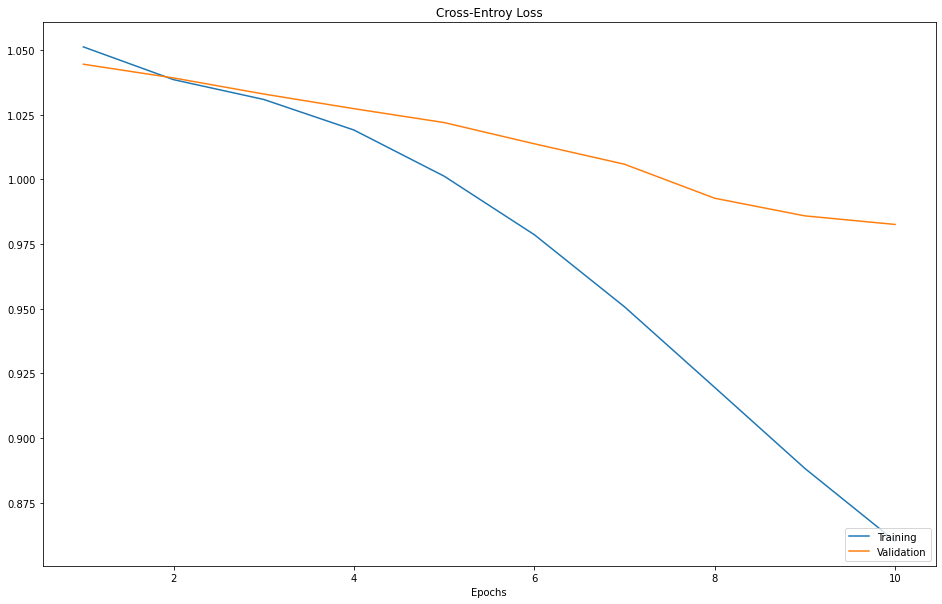

In [163]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(np.arange(1, len(deep_classifier_history.epoch) + 1), deep_classifier_history.history['Cross-Entropy'],
             label='Training Loss')
ax.plot(np.arange(1, len(deep_classifier_history.epoch) + 1), deep_classifier_history.history['val_Cross-Entropy'],
             label='Validation Loss')
ax.set_title('Cross-Entroy Loss')
ax.legend(['Training', 'Validation'], loc='lower right')
plt.xlabel('Epochs')

plt.show()

Mean cross-entropy loss:

In [166]:
np.mean(deep_classifier_history.history['Cross-Entropy'])

0.9738587379455567

In [167]:
np.mean(deep_classifier_history.history['val_Cross-Entropy'])

1.014726984500885

**Strong overfitting** indicated by the plot. On average, similar results to the XGB classifier. Definitely improvements via hyper-parameter tuning possible. However, we will continue with predictions:

In [168]:
deep_classifier_predictions_probabilities = deep_classifier.predict(features_valid)

In [169]:
deep_classifier_predictions = np.argmax(deep_classifier_predictions_probabilities, axis=1)

In [170]:
deep_classifier_confusion_matrix = confusion_matrix(targets_valid, deep_classifier_predictions)

In [171]:
deep_classifier_confusion_matrix_plot = ConfusionMatrixDisplay(deep_classifier_confusion_matrix,
                                                               display_labels=np.array(['draw', 'home', 'away']))

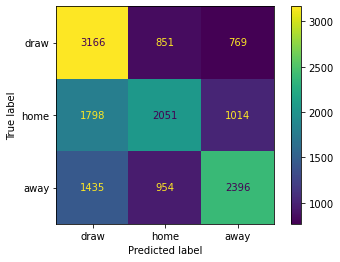

In [172]:
deep_classifier_confusion_matrix_plot.plot()

Make predictions on the test data and save the results:

In [173]:
deep_classifier_predictions_test = deep_classifier.predict(features_test_scaled)

In [182]:
submission_deep_classifier = pd.DataFrame(deep_classifier_predictions_test, columns=['draw', 'home', 'away'])

In [183]:
submission_deep_classifier = pd.concat([pd.Series(test_data.index, name='id'),
                                        submission_deep_classifier[['home', 'away', 'draw']]], axis=1)

In [187]:
# submission_deep_classifier.to_csv('submission_nn.csv', index=False)